# Spectral Flowed Sectors: Maldacena-Ooguri bounds

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import csv

In [2]:
def jedge(k,omega,N):
    if omega % 2 == 0 and 1 + k*(-2 + 4*N*(1 + omega)) >= 0:
        #omega is even and j is real
        return (1/2)*(1 - k*omega + np.sqrt(1 + k*(-2 + 4*N*(1 + omega))))
    elif omega % 2 != 0 and 1 + 2*k*(-1 + 2*N)*(1 + omega) >=0:
        #omega is odd and j is real
        return (1/2)*(1 - k*omega + np.sqrt(1 + 2*k*(-1 + 2*N)*(1 + omega)))
    else:
        #j is complex
        return -1

In [3]:
#now we want jedge > 1/2
def get_first_N(k,omega):
    if omega % 2 == 0:
        #omega is even
        return np.rint((k*k*omega*omega+2*k-1)/(4*k + 4*k*omega))
    else:
        #omega is odd
        return np.rint((k*k*omega*omega+2*k+2*k*omega-1)/(4*k + 4*k*omega))

In [4]:
def get_values_of_N(k,omega):
    allowed_N = []
    N = get_first_N(k,omega)
    while jedge(k,omega,N) < (k+1)/2:
        if jedge(k,omega,N) != -1:
            #if j is not complex, we add the corresponding N to the list of allowed values
            allowed_N.append(N)
        N += 1
    return allowed_N

In [5]:
def j(k,omega,N,r):
    if 1 + k*(4*N - 2*(1 + omega + 2*omega*r)) >= 0:
        #j is real
        return (1/2)*(1 - k*omega + np.sqrt(1 + k*(4*N - 2*(1 + omega + 2*omega*r))))
    else:
        #j is complex
        return -1

In [6]:
def get_N_and_r(k,omega):
    allowedN = get_values_of_N(k,omega)
    omega_N_r = [] 
    for elem in allowedN:
        #Initialize at the proper value of r
        if omega % 2 == 0:
            #omega is even 
            r = - elem -(1/2)
        else:
            #omega is odd
            r = -elem
        if omega != 0 :
            while j(k,omega,elem,r) != -1 and j(k,omega,elem,r) > (1/2):
                #If j is real and greater than zero, we append the corresponding r to the list of allowed values
                omega_N_r.append([omega,elem,r])
                r+=1
        else:
            while r <= elem + (1/2):
                omega_N_r.append([omega,elem,r])
                r+=1
    return omega_N_r

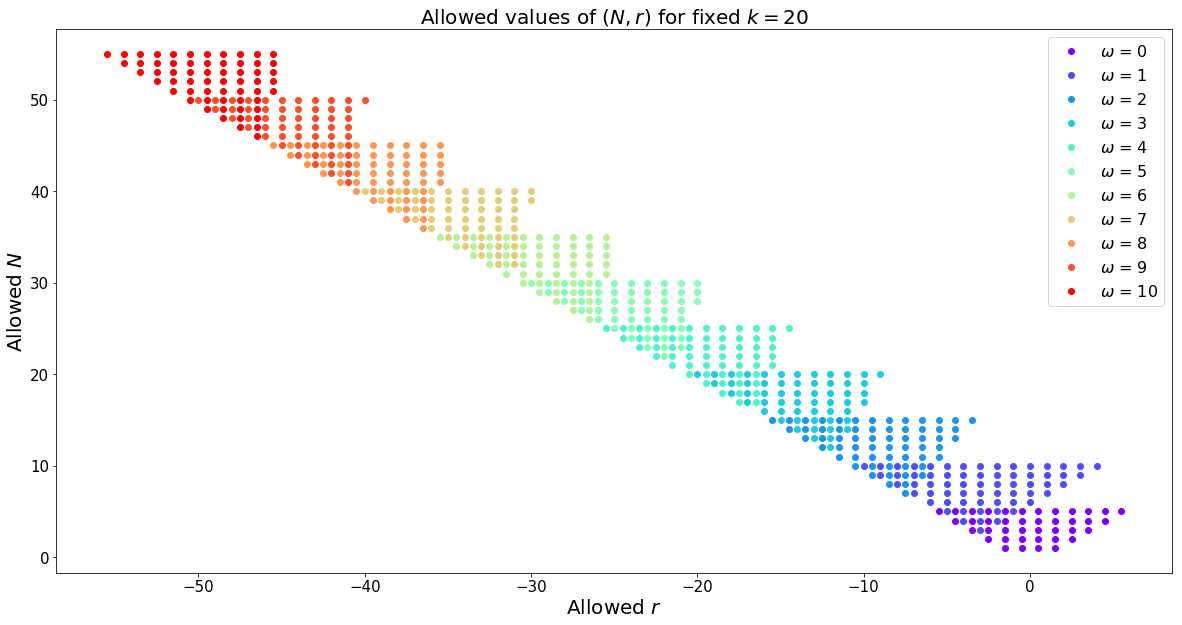

In [7]:
#Fix k
k=20
#Fix the number of different omegas to plot
n=10
#Assign colors to the different omegas
color=iter(cm.rainbow(np.linspace(0,1,n+1)))
plt.figure(figsize=(20,10))
for omega in range(0,n+1):
    df = pd.DataFrame(get_N_and_r(k,omega),columns=['omega', 'N', 'r'])
    plotraxis = df['r']
    plotNaxis = df['N']
    c=next(color)
    plt.plot(plotraxis, plotNaxis,c=c,linestyle='',marker ='o',label = '$\omega$ = %d' %omega)

plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Allowed $r$',fontsize=20)
plt.ylabel('Allowed $N$',fontsize=20)
plt.title('Allowed values of $(N,r)$ for fixed $k = %d$'%k,fontsize=20) 
plt.show()

In [8]:
def physical_states(k,omega):
    finalarray = []
    for elem in get_N_and_r(k,omega):
        for elem2 in get_N_and_r(k,omega):
            if elem[1]-elem2[1]== elem[0]*(elem[2]-elem2[2]):
            #If level-matching is satisfied, store the tuple (omega, N, r, bar{N},bar{r},j,E,s)
                finalarray.append([k,elem[0],elem[1],elem[2],elem2[1],elem2[2],j(k,elem[0],elem[1],elem[2]),
                               2*j(k,elem[0],elem[1],elem[2])+elem[2]+elem2[2]+k*elem[0],elem[2]-elem2[2]])
    return pd.DataFrame(finalarray,columns=['k','omega', 'N', 'r','N bar','r bar','j','E','s'])

In [9]:
def physical_by_j(k,omega):
    #Compute the physical states:
    df=physical_states(k,omega)
    #Pull out a list of the values of j that occur:
    list_of_j = df['j'].unique()
    #For every element on this list, generate the corresponding sub-dataframe:
    i=0
    list_of_subframes = {};
    for elem in list_of_j:
        list_of_subframes['frame_{}'.format(i)] = df[df['j']==elem] 
        i+=1
    return list_of_subframes

In [10]:
def Regge(k,omega):
    #Compute the physical states:
    df=physical_states(k,omega)       
    #Group them by spin and slice out the one with minimal energy
    #temp = df.loc[df.groupby('s').E.idxmin()].reset_index(drop=True)
    temp = df[df.E==df.groupby('s').E.transform('min')].sort_values(['s'],ascending=True).reset_index(drop=True)
    return temp

In [11]:
def get_further_N(k,omega,s_max):
    further_allowed_N = []
    #the starting level is now the maximum level allowed at the edge
    Nmax_plus_one = max(get_values_of_N(k,omega)) + 1
    Nmin = min(get_values_of_N(k,omega))
    N = Nmax_plus_one
    if omega !=0:
        s = (N - Nmin)/omega
        while s <= s_max:
            further_allowed_N.append(N)
            s += 1/omega
            N += 1
    return further_allowed_N

In [12]:
def get_further_N_and_r(k,omega,s_max):
    further_allowed_N = get_further_N(k,omega,s_max)
    omega_N_r = [] 
    if omega != 0:
        for elem in further_allowed_N:
            non_unitary_r = []
            if omega % 2 == 0:
                #omega is even 
                r = - elem -(1/2)
            else:
                r = - elem
            while j(k,omega,elem,r) >= ((k+1)/2):
                non_unitary_r.append(r)
                r+=1
        
            rmin = max(non_unitary_r)+1
            while j(k,omega,elem,rmin) != -1 and j(k,omega,elem,rmin) > (1/2):
                omega_N_r.append([omega,elem,rmin])
                rmin += 1
            
    return omega_N_r

In [13]:
def all_N_and_r(k,omega,s_max):
    N_and_r=[]
    for elem1 in get_N_and_r(k,omega):
        N_and_r.append(elem1)
    for elem2 in get_further_N_and_r(k,omega,s_max):
        N_and_r.append(elem2)
    return N_and_r

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

#fix rmax
s_max=4
#Fix k
k=20
#Fix the number of different omegas to plot
n=10
#Assign colors to the different omegas
color=iter(cm.rainbow(np.linspace(0,1,n+1)))
plt.figure(figsize=(20,10))
for omega in range(0,n+1):
    dffurther = pd.DataFrame(all_N_and_r(k,omega,s_max),columns=['omega', 'N', 'r'])
    raxis = dffurther['r']
    Naxis = dffurther['N']
    c=next(color)
    plt.plot(raxis, Naxis,c=c,linestyle='',marker ='o',label = '$\omega$ = %d' %omega)
    
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Allowed $r$',fontsize=20)
plt.ylabel('Allowed $N$',fontsize=20)
plt.title('Allowed values of $(N,r)$ for fixed $k = %d$'%k,fontsize=20) 
    
plt.show()

In [14]:
def all_physical_states(k,omega,s_max):
    all_finalarray = []
    for elem in all_N_and_r(k,omega,s_max):
        for elem2 in all_N_and_r(k,omega,s_max):
            if elem[1]-elem2[1]== elem[0]*(elem[2]-elem2[2]):
            #If level-matching is satisfied, store the tuple (omega, N, r, bar{N},bar{r},j,E,s)
                all_finalarray.append([k,elem[0],elem[1],elem[2],elem2[1],elem2[2],j(k,elem[0],elem[1],elem[2]),
                               2*j(k,elem[0],elem[1],elem[2])+elem[2]+elem2[2]+k*elem[0],elem[2]-elem2[2]])
    return pd.DataFrame(all_finalarray,columns=['k','omega', 'N', 'r','N bar','r bar','j','E','s'])

In [15]:
def all_physical_by_j(k,omega,s_max):
    #Compute the physical states:
    df=all_physical_states(k,omega,s_max)
    #Pull out a list of the values of j that occur:
    list_of_j = df['j'].unique()
    #For every element on this list, generate the corresponding sub-dataframe:
    i=0
    list_of_subframes = {};
    for elem in list_of_j:
        list_of_subframes['frame_{}'.format(i)] = df[df['j']==elem] 
        i+=1
    return list_of_subframes

In [ ]:
#Set (k,omega)
k=10
omega=1
s_max=4
#We first determine and store the number of subframes (i.e. of different values of j that occur)
n = len(all_physical_by_j(k,omega,s_max))
#Then we assign a color to each of them
color=iter(cm.rainbow(np.linspace(0,2,n+1)))
plt.figure(figsize=(20,15))
#Loop over the subframes
for i in range(1,n+1):
    #Slice out the desired subframe
    current_subframe=all_physical_by_j(k,omega,s_max)['frame_{}'.format(i-1)]
    #Store its j value
    current_j= current_subframe['j'].iloc[0]
    
    Eaxis = current_subframe['E']
    saxis = current_subframe['s']
    c=next(color)
    plt.plot(saxis, Eaxis,c=c,linestyle='',marker ='o',label = 'j = %f' %current_j)

plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Spacetime spin $s$',fontsize=20)
plt.ylabel('Spacetime Energy $E$',fontsize=20)
plt.title('$sl(2,R)$ reps for for fixed $(k,\omega)=$(%d,%d)'%(k,omega),fontsize=20) 
plt.show()

In [16]:
def all_Regge(k,omega,s_max):
    #Compute the physical states:
    df=all_physical_states(k,omega,s_max)       
    #Group them by spin and slice out the one with minimal energy
    temp = df[df.E==df.groupby('s').E.transform('min')].sort_values(['s'],ascending=True).reset_index(drop=True)
    #temp = df.loc[df.groupby('s').E.idxmin()].reset_index(drop=True)
    return temp

In [17]:
def Econt(k,omega,s):
    if omega % 2 == 0:
        return np.absolute(s) + (k*omega) / 2 +   1/(2*k*omega)
    else:
        return np.absolute(s) + (k*omega) / 2 +   ( 1/(2*k) - 1) / omega

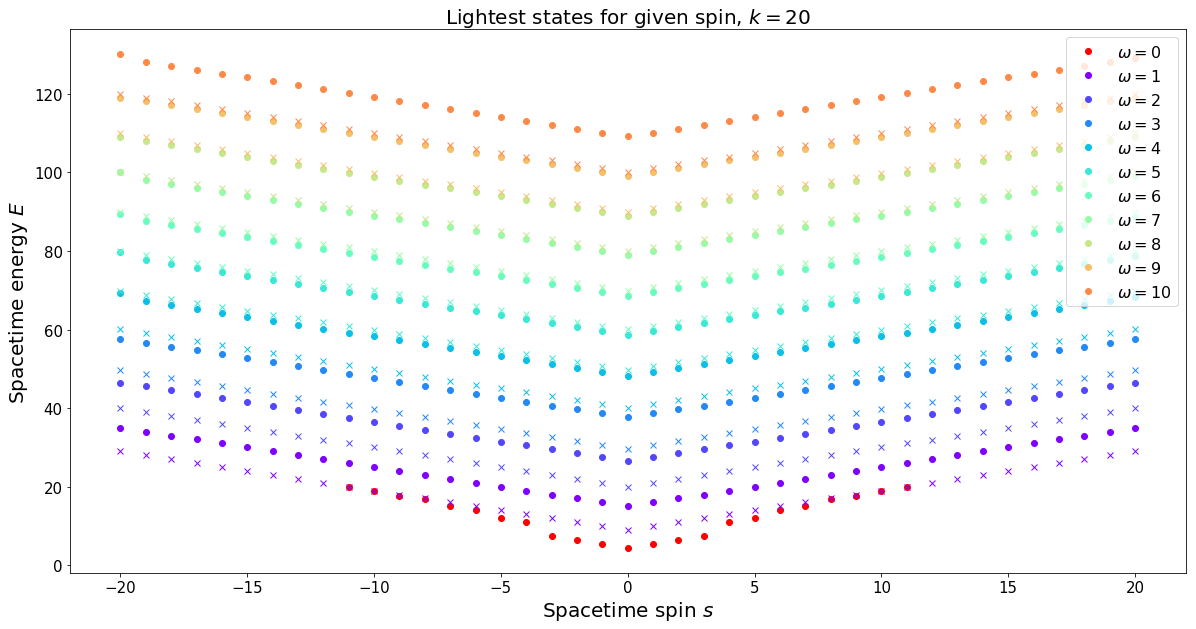

In [18]:
#Fix k
k=20
s_max=20
#Fix the number of different omegas to plot
n=10
#Assign colors to the different omegas
color=iter(cm.rainbow(np.linspace(0,1,n+2)))
plt.figure(figsize=(20,10))
df_zero = all_Regge(k,0,s_max)
s_zero = df_zero['s']
E_zero = df_zero['E']
plt.plot(s_zero, E_zero,c='red',linestyle='',marker = 'o',label = '$\omega = 0$')

for omega in range(1,n+1):
    df = all_Regge(k,omega,s_max)
    spins = df['s']
    energies = df['E']
    s_axis = []
    for elem in spins:
        s_axis.append(elem)
    E_axis = []
    for elem in energies:
        E_axis.append(elem)
    while max(s_axis) < s_max:
        s_axis.append(max(s_axis)+1)
        s_axis.append(min(s_axis)-1)
        E_axis.append(max(E_axis)+1)
        E_axis = [max(E_axis)+1] + E_axis
    s_axis.sort()
    E_cont=[]
    for elem in s_axis:
        E_cont.append(Econt(k,omega,elem))
    c=next(color)
    plt.plot(s_axis,E_axis,c=c,linestyle='',marker ='o',label = '$\omega=%d$'%omega)
    plt.plot(s_axis, E_cont,c=c,linestyle='',marker='x')

leg=plt.legend(fontsize=16, loc='upper right')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Spacetime spin $s$',fontsize=20)
plt.ylabel('Spacetime energy $E$',fontsize=20)
plt.title('Lightest states for given spin, $k = %d$'%k,fontsize=20) 
plt.savefig('Regges.png')

plt.show()

In [ ]:
number_after_Nmax=4
#Fix k
k=17
df_omega1 = pd.DataFrame(all_N_and_r(k,1,number_after_Nmax),columns=['omega', 'N', 'r'])
raxis_omega1 = df_omega1['r']
Naxis_omega1 = df_omega1['N']
plt.plot(raxis_omega1, Naxis_omega1,c=c,linestyle='',marker ='o')
    
plt.tick_params(axis='both', which='major')
plt.xlabel('Allowed $r$',fontsize=10)
plt.ylabel('Allowed $N$',fontsize=10)
plt.title('Allowed values of $(N,r)$ for fixed $k = %d$, $\omega = %d$'%(k,1),fontsize=12) 
    
plt.show()

In [ ]:
import math
def j_vertex_omega1(kmax):
    j_range=[]
    k=2
    while k <= kmax:
        if ((k+2)/8) % 1 == 0:
            j_range.append(j(k,1,((k+2)/8)+1,-((k+2)/8)-1))
        else:
            j_range.append (j(k,1,math.ceil(((k+2)/8)),-math.ceil(((k+2)/8))))
        k+=1
    return j_range

In [ ]:
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

import matplotlib.pyplot as plt

pgf_with_latex = {
    "text.usetex": True,            # use LaTeX to write all text
    "pgf.rcfonts": False,           # Ignore Matplotlibrc
    "pgf.preamble": [
        r'\usepackage{color}'     # xcolor for colours
    ]
}
matplotlib.rcParams.update(pgf_with_latex)

plt.figure()
plt.ylabel(r'\textcolor{red}{Today} '+
           r'\textcolor{green}{is} '+
           r'\textcolor{blue}{cloudy.}')
plt.savefig("test.pdf")